In [202]:
import os
import tensorflow as tf
from tensorflow import keras
AUTOTUNE = tf.data.experimental.AUTOTUNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import kaggle
from definitions import *

# Preprocess files from raw dataset

#### Data should be downloaded as it was done in data analysis ipynb file and it should be storred in "raw_data" folder and each subfolders should be called wih the class name and should consists files from corresponding class

### Create list of files and labels

In [203]:
subdirs = [f.name for f in os.scandir(raw_data_dir) if f.is_dir()]

files = []
for subdir in subdirs:
    subdir_path = os.path.join(raw_data_dir, subdir)
    files += [os.path.join(subdir_path, f.name) for f in os.scandir(subdir_path) if f.is_file()]

# Remove not images from dataset
not_jpg = [f for f in files if not f.endswith(".jpg")]
files = [file for file in files if file not in not_jpg]

# Sort files to maintain order
files = sorted(files)

labels = [file.split("\\")[-2] for file in files]

### Encode labels

In [204]:
label2index = dict((label, index) for index, label in enumerate(sorted(set(labels))))
encoded_labels = [label2index[label] for label in labels]

In [209]:
print(set(encoded_labels))
print(len(encoded_labels))

{0, 1, 2, 3}
11420
0


### Split files into training, testing and validation

In [172]:
NUMBER_OF_FILES  = len(files)
NUMBER_OF_LABELS = len(label2index)

In [173]:
from sklearn.model_selection import train_test_split

train_files, test_files, train_labels, test_labels = train_test_split(files,
                                                                      encoded_labels,
                                                                      test_size=TEST_SPLIT_FACTOR,
                                                                      random_state=1969)

train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels,
                                                                    test_size=VAL_SPLIT_FACTOR,
                                                                    random_state=1969)

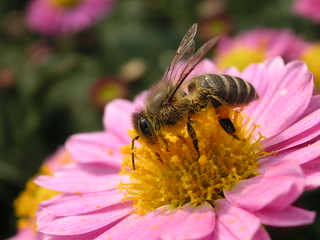

In [175]:
import IPython.display as display
display.display(display.Image('raw_data/bee/1240800_e5f2b40032_n.jpg'))

In [207]:
from collections import Counter
images_count_org = Counter()

# Checks how many images from each class we have
def countByClass(files):
    for file in files:
        label = file.split("\\")[-2]
        name = file.split("\\")[-1]

        images_count_org[label] += 1

    return images_count_org

In [208]:
print(countByClass(train_files))
print(countByClass(test_files))
print(countByClass(val_files))

Counter({'wasp': 4942, 'bee': 3183, 'other_insect': 2439, 'other_noinsect': 856})
Counter({'wasp': 5962, 'bee': 3799, 'other_insect': 2920, 'other_noinsect': 1023})
Counter({'wasp': 6758, 'bee': 4284, 'other_insect': 3335, 'other_noinsect': 1155})


### Data augmentation on: train_files, test_files, val_files

In [195]:
# TEST on one image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from random import randint

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

def prepare_augmented_data(files_to_augment, output_dir):
    flow_counter = 0
    for img_path in files_to_augment: 

        img_path = img_path.replace("\\", "/")

        img = load_img(img_path)
        x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
        x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

        # the .flow() command below generates batches of randomly transformed images

        label = img_path.split("/")[-2]

        if label == 'bee':
            augmentation_factor = 8
        elif label == 'wasp':
            augmentation_factor = 5
        elif label == 'other_insect':
            augmentation_factor = 10
        elif label == 'other_noinsect':
            augmentation_factor = 29
        
        # save orginal image 
        img.save(output_dir + "//" + label + "//" + img_path.split("/")[-1])
          
        prefix = randint(0, 10000)
        
        i = 0
        for batch in datagen.flow(x,
                                  batch_size=1,
                                  save_to_dir = output_dir + "//" + label,
                                  save_prefix=str(flow_counter) + "_" + str(prefix) + "__",
                                  save_format='jpeg'):

            i += 1
            if i >=augmentation_factor:
                flow_counter += i
                break  # otherwise the generator would loop indefinitely
                
    return flow_counter

### Uncomment below if you want to generate augmented data
Make sure you have folders: "train_files", "test_files", "val_files" and in each of it empty subfolders: "bee", "wasp", "other_noinsect", "other_insect"

In [181]:
#counter_train = prepare_augmented_data(train_files, "train_files")
#counter_test = prepare_augmented_data(test_files, "test_files")
#counter_val = prepare_augmented_data(val_files, "val_files")

In [182]:
# Checks how many times flow functions was called
print(counter_train)
print(counter_test)
print(counter_val)

63869
19681
15838


### Prepare list with file names and correspondig labels for train test and val files from newly augmentet data

In [211]:
def prepare_augmented_split_data(data_dir):
    subdirs = [f.name for f in os.scandir(data_dir) if f.is_dir()]
  
    files = []
    for subdir in subdirs:
        subdir_path = os.path.join(raw_data_dir, subdir)
        files += [os.path.join(subdir_path, f.name) for f in os.scandir(subdir_path) if f.is_file()]

    # Remove not images from dataset
    not_jpg = [f for f in files if not f.endswith(".jpg")]
    files = [file for file in files if file not in not_jpg]

    # Sort files to maintain order
    files = sorted(files)

    labels = [file.split("\\")[-2] for file in files]
    
    label2index = dict((label, index) for index, label in enumerate(sorted(set(labels))))
    encoded_labels = [label2index[label] for label in labels]

    return files, encoded_labels

In [214]:
train_files, train_labels = prepare_augmented_split_data("train_files")
test_files, test_labels = prepare_augmented_split_data("test_files")
val_files, val_labels = prepare_augmented_split_data("val_files")

### Prepare images in dataset

In [216]:
# scale all images to 224x224 - default image size in vgg19 nn model
def prepare_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(
        image,
        optimize_size=True,
        x_density=96,
        y_density=96
    )

    return image

def load_and_prepare_image(path):
    image = tf.io.read_file(path)
    return prepare_image(image)

# Create TFRecord files

### Create split datasets

In [217]:
train_images_ds = tf.data.Dataset.from_tensor_slices(train_files)
test_images_ds  = tf.data.Dataset.from_tensor_slices(test_files)
val_images_ds   = tf.data.Dataset.from_tensor_slices(val_files)

train_labels_ds = tf.data.Dataset.from_tensor_slices(train_labels)
test_labels_ds  = tf.data.Dataset.from_tensor_slices(test_labels)
val_labels_ds   = tf.data.Dataset.from_tensor_slices(val_labels)

### Apply preprocessing to images datasets

In [218]:
train_images_ds = train_images_ds.map(load_and_prepare_image, num_parallel_calls=4)
test_images_ds  =  test_images_ds.map(load_and_prepare_image, num_parallel_calls=4)
val_images_ds   =   val_images_ds.map(load_and_prepare_image, num_parallel_calls=4)

### Save images datasets to binary files

In [219]:
train_images_ds = train_images_ds.map(tf.io.serialize_tensor, num_parallel_calls=4)
test_images_ds  =  test_images_ds.map(tf.io.serialize_tensor, num_parallel_calls=4)
val_images_ds   =   val_images_ds.map(tf.io.serialize_tensor, num_parallel_calls=4)

train_writer = tf.data.experimental.TFRecordWriter(train_images_file)
test_writer  = tf.data.experimental.TFRecordWriter( test_images_file)
val_writer   = tf.data.experimental.TFRecordWriter(  val_images_file)

# <span style="color:red">Do not use the commented code below!!!</span>
### ...unless you're 100% sure you know why are you doing this
This will override our dataset and it will be no longer consistent with a previous version

In [221]:
 train_writer.write(train_images_ds)
 test_writer.write(test_images_ds)
 val_writer.write(val_images_ds)

### Save labels datasets to binary files

In [222]:
train_labels_ds = train_labels_ds.map(tf.io.serialize_tensor, num_parallel_calls=4)
test_labels_ds  =  test_labels_ds.map(tf.io.serialize_tensor, num_parallel_calls=4)
val_labels_ds   =   val_labels_ds.map(tf.io.serialize_tensor, num_parallel_calls=4)

train_writer = tf.data.experimental.TFRecordWriter(train_labels_file)
test_writer  = tf.data.experimental.TFRecordWriter( test_labels_file)
val_writer   = tf.data.experimental.TFRecordWriter(  val_labels_file)

# <span style="color:red">Do not use the commented code below!!!</span>
### ...unless you're 100% sure you know why are you doing this
This will override our dataset and it will be no longer consistent with a previous version

In [223]:
train_writer.write(train_labels_ds)
test_writer. write(test_labels_ds)
val_writer.  write(val_labels_ds)